## Load Data


In [11]:
import pandas as pd
import numpy as np
import json
import pywt
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

In [12]:
# All: 40000 rows, 50%: 20000 rows, 10%: 4000 rows
# Load the data
nr_rows = 40000
df = pd.read_csv('./data/all.csv', nrows=nr_rows)

# Extract torque and angle outside the loop
torque_data = df["Torque"].apply(json.loads)
angle_data = df["Angle"].apply(json.loads)

# Initialize lists to store processed data
processed_data = []

for sample in range(nr_rows):
    # Extract torque and angle for the current sample
    torque = pd.DataFrame(torque_data[sample][0]['Rows'], columns=["Time", "Torque"]).drop(columns=["Time"])
    angle = pd.DataFrame(angle_data[sample][0]['Rows'], columns=["Time", "Angle"])

    # Combine torque and angle data
    total_data = pd.concat([angle, torque], axis=1)
    total_data['Kleiner_als_vorher'] = total_data["Angle"] > total_data["Angle"].shift(1)
    total_data['Kumulatives_Produkt'] = (total_data['Kleiner_als_vorher'][1:].astype(int)).cumprod()

    # Separate the sections based on 'Kumulatives_Produkt'
    rotation_data = total_data.drop(columns=["Time", 'Kleiner_als_vorher', "Kumulatives_Produkt"])

    # Ensure the dataframe has the same shape by truncating or padding
    max_len = 836  # Define the target length
    rotation_data = rotation_data.head(max_len).reindex(range(max_len), fill_value=0)

    # Add the processed data to the list
    processed_data.append(rotation_data)

# Convert the list to a numpy array
processed_data_array = np.array(processed_data)


## Data Info

In [13]:
# Assuming 'processed_data_array' is the numpy array containing the processed data
# Verify the number of samples
num_samples = processed_data_array.shape[0]
#assert num_samples == 624, f"Expected 624 samples, but got {num_samples}"

# Calculate statistics for torque and angle
# Assuming the structure: processed_data_array[sample_index, time_index, column_index]
# Column 0: Angle, Column 1: Torque
angle_data = processed_data_array[:, :, 0]
torque_data = processed_data_array[:, :, 1]

# Flatten the data to compute overall statistics
flattened_angle = angle_data.flatten()
flattened_torque = torque_data.flatten()

# Calculate statistics
angle_stats = {
    'mean': np.mean(flattened_angle),
    'std_dev': np.std(flattened_angle),
    'min': np.min(flattened_angle),
    'max': np.max(flattened_angle)
}

torque_stats = {
    'mean': np.mean(flattened_torque),
    'std_dev': np.std(flattened_torque),
    'min': np.min(flattened_torque),
    'max': np.max(flattened_torque)
}

# Print statistics
print(f"Number of samples: {num_samples}")
print("\nAngle Statistics:")
print(f"Mean: {angle_stats['mean']}")
print(f"Standard Deviation: {angle_stats['std_dev']}")
print(f"Minimum: {angle_stats['min']}")
print(f"Maximum: {angle_stats['max']}")

print("\nTorque Statistics:")
print(f"Mean: {torque_stats['mean']}")
print(f"Standard Deviation: {torque_stats['std_dev']}")
print(f"Minimum: {torque_stats['min']}")
print(f"Maximum: {torque_stats['max']}")

Number of samples: 40000

Angle Statistics:
Mean: 162.5157698534477
Standard Deviation: 111.13674332654338
Minimum: 0.16840000000000002
Maximum: 359.732

Torque Statistics:
Mean: 16.357292538875598
Standard Deviation: 20.795608058070393
Minimum: -50.300000000000004
Maximum: 79.9


## Wavelet Transform


In [14]:
# Initialize lists to store the transformed data
transformed_data = []

for sample in range(processed_data_array.shape[0]):
    # Apply DWT to both angle and torque data
    coeffs_angle = pywt.dwt(processed_data_array[sample, :, 0], 'db1')
    coeffs_torque = pywt.dwt(processed_data_array[sample, :, 1], 'db1')
    
    # Extract approximation coefficients (cA)
    cA_angle = coeffs_angle[0]
    cA_torque = coeffs_torque[0]
    
    # Combine the coefficients into a single feature vector
    combined_coeffs = np.concatenate((cA_angle, cA_torque))
    
    # Append to the transformed data list
    transformed_data.append(combined_coeffs)

# Convert transformed data to a numpy array
transformed_data_array = np.array(transformed_data)

## K-Means Clustering

In [15]:

# Define the number of clusters (k)
num_clusters = 4  # You can choose an appropriate number of clusters

# Initialize and fit the KMeans model
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
kmeans.fit(transformed_data_array)

# Get the cluster labels
cluster_labels = kmeans.labels_

# Print the cluster labels for each sample
print("Cluster labels for each sample:")
print(cluster_labels)

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x775180254ca0>
Traceback (most recent call last):
  File "/home/admin-anedunga/anaconda3/envs/Indas2/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/admin-anedunga/anaconda3/envs/Indas2/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/admin-anedunga/anaconda3/envs/Indas2/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/admin-anedunga/anaconda3/envs/Indas2/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'


Cluster labels for each sample:
[0 0 0 ... 0 0 0]


## K-Shape Clustering

0.000 --> 0.000 --> 


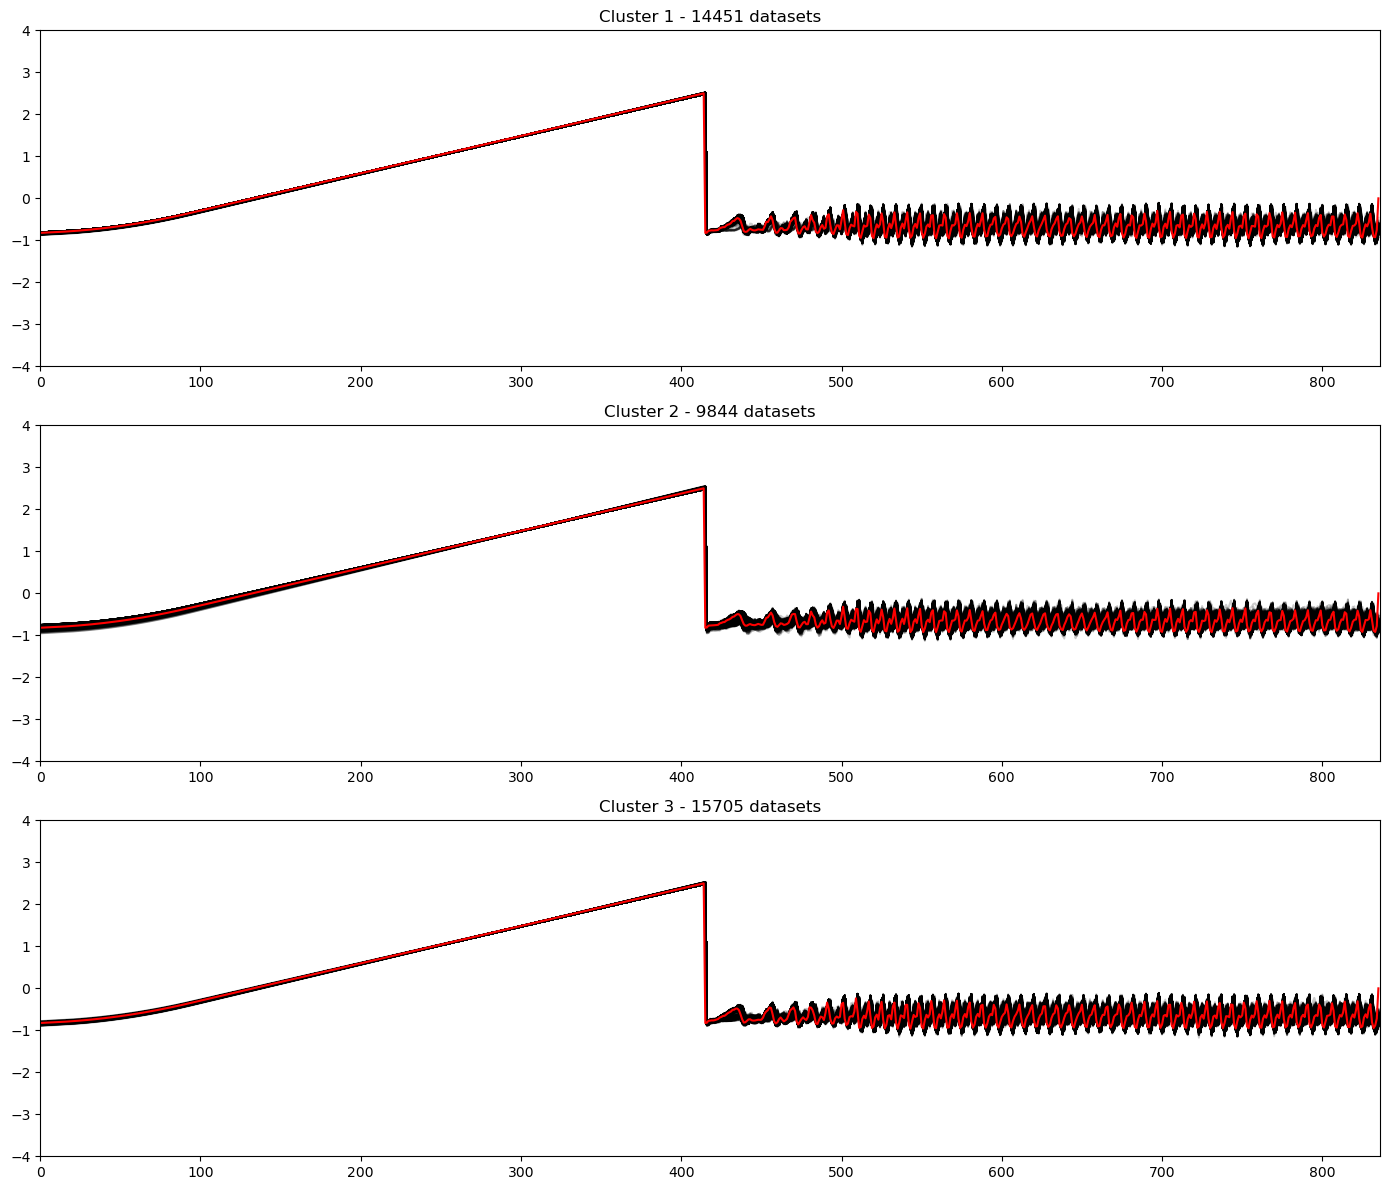

In [16]:
from tslearn.clustering import KShape
from tslearn.datasets import CachedDatasets
from tslearn.preprocessing import TimeSeriesScalerMeanVariance
import matplotlib.pyplot as plt

# For this method to operate properly, prior scaling is required
X_train = TimeSeriesScalerMeanVariance().fit_transform(transformed_data_array)
sz = X_train.shape[1]

seed = 0
np.random.seed(seed)
clusters=3

# kShape clustering
ks = KShape(n_clusters=clusters, verbose=True, random_state=seed,max_iter=10)
y_pred = ks.fit_predict(X_train)

plt.figure(figsize=(14, 12))  # Increase figure size for a wider plot

for yi in range(clusters):
    plt.subplot(clusters, 1, 1 + yi)
    cluster_data = X_train[y_pred == yi]
    for xx in cluster_data:
        plt.plot(xx.ravel(), "k-", alpha=.2)
    plt.plot(ks.cluster_centers_[yi].ravel(), "r-")
    plt.xlim(0, sz)
    plt.ylim(-4, 4)
    plt.title(f"Cluster {yi + 1} - {len(cluster_data)} datasets")  # Display number of datasets

plt.tight_layout()
plt.show()

## Scalograms

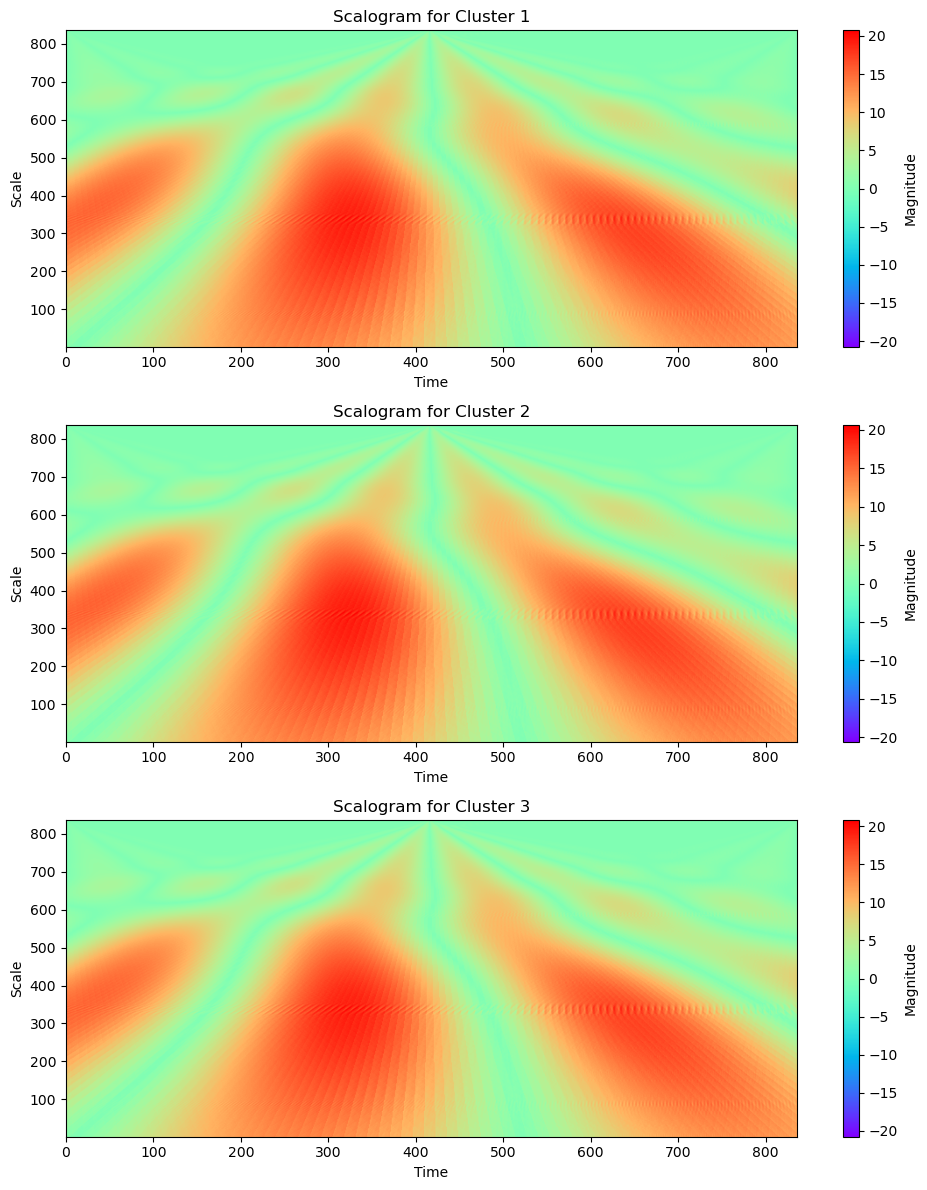

In [18]:
# Plot magnitude scalogram for each cluster
plt.figure(figsize=(10, 12))

for yi in range(clusters):
    plt.subplot(clusters, 1, 1 + yi)
    cluster_center = ks.cluster_centers_[yi].ravel()
    
    # Perform continuous wavelet transform
    scales = np.arange(1, sz+1)
    coef, freqs = pywt.cwt(cluster_center, scales, 'morl')
    
    # Plot scalogram
    plt.imshow(np.abs(coef), extent=[0, sz, 1, scales[-1]], cmap='rainbow', aspect='auto',
               vmax=abs(coef).max(), vmin=-abs(coef).max())
    plt.colorbar(label='Magnitude')
    plt.title(f'Scalogram for Cluster {yi + 1}')
    plt.ylabel('Scale')
    plt.xlabel('Time')
    plt.ylim(1, scales[-1])
    
plt.tight_layout()
plt.show()

# 1 & 3, 5 Same
# 4 & 6 Same